In [35]:
import xarray as xr
import pandas as pd
import numpy as np
import qnt.data    as qndata  # load and manipulate data
import qnt.output as qnout   # manage output
import qnt.backtester as qnbt # backtester
import qnt.stats   as qnstats # statistical functions for analysis
import qnt.graph   as qngraph # graphical tools
import qnt.ta      as qnta    # indicators library
import qnt.xr_talib as xr_talib   # indicators library

In [36]:
data = qndata.stocks.load_ndx_data(min_date="2005-01-01")

fetched chunk 1/6 0s
fetched chunk 2/6 0s
fetched chunk 3/6 0s
fetched chunk 4/6 0s
fetched chunk 5/6 0s
fetched chunk 6/6 0s
Data loaded 1s


In [54]:
def strategy(data):
    close = data.sel(field="close")
    open_price = data.sel(field="open")
    rsi_14 = qnta.rsi(close, 14)
    
    # Set stop-loss and take-profit levels
    stop_loss = 0.05 
    take_profit = 0.10 
    
    # Assign weights based on RSI condition
    weights = xr.where(rsi_14 < 30, 1, 0)  # Buy signal
    weights = xr.where(rsi_14 > 70, -1, weights)  # Sell signal
    
    # Apply stop-loss and take-profit levels
    returns = (close - open_price) / open_price
    weights = xr.where(returns <= -stop_loss, 0, weights)  # Exit long position if stop-loss is triggered
    weights = xr.where(returns >= take_profit, 0, weights)  # Exit long position if take-profit is triggered
    
    # Apply liquidity filter
    is_liquid = data.sel(field="is_liquid")
    weights = weights * is_liquid
    
    # Clean weights
    weights = qnout.clean(weights, data, "stocks_nasdaq100")
    
    return weights


weights = strategy(data)

Output cleaning...
fix uniq
ffill if the current price is None...
Check liquidity...
Ok.
Check missed dates...
Ok.
Normalization...
Output cleaning is complete.


In [55]:
stats = qnstats.calc_stat(data, weights.sel(time=slice("2005-01-01", None)))
display(stats.to_pandas().tail())

field,equity,relative_return,volatility,underwater,max_drawdown,sharpe_ratio,mean_return,bias,instruments,avg_turnover,avg_holding_time
time,,,,,,,,,,,
2024-04-04,0.002798,-0.001336,0.251877,-0.997356,-0.997356,-1.045577,-0.263357,0.250000,241.0,0.811206,2.374641
2024-04-05,0.002781,-0.006096,0.251854,-0.997372,-0.997372,-1.046419,-0.263545,0.200000,241.0,0.811227,2.374734
2024-04-08,0.002772,-0.003058,0.251828,-0.997380,-0.997380,-1.046807,-0.263615,0.250000,241.0,0.811144,2.374884
2024-04-09,0.002792,0.007317,0.251809,-0.997361,-0.997380,-1.045592,-0.263290,0.200000,241.0,0.811060,2.374795
2024-04-10,0.002748,-0.015984,0.251806,-0.997403,-0.997403,-1.047868,-0.263860,0.666667,241.0,0.811099,2.376017


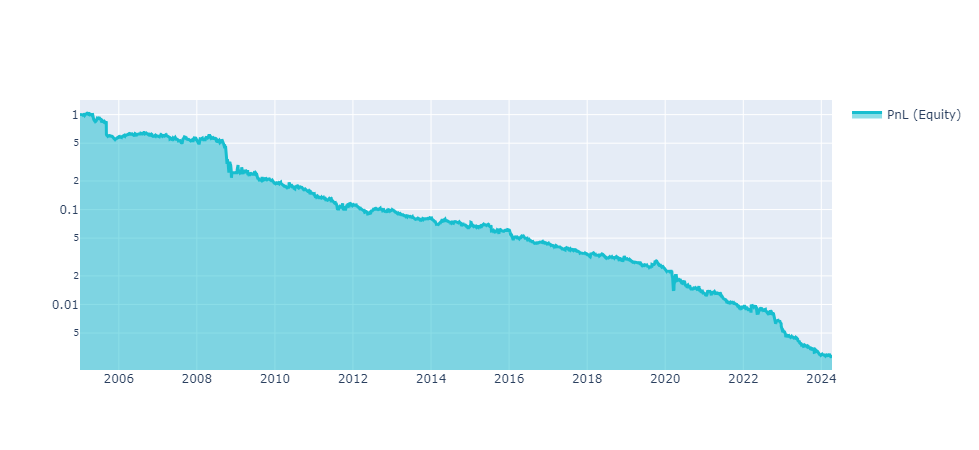

In [56]:
performance = stats.to_pandas()["equity"]
qngraph.make_plot_filled(performance.index, performance, name="PnL (Equity)", type="log")

In [57]:
weights = weights.sel(time=slice("2006-01-01",None))

qnout.check(weights, data, "stocks_nasdaq100")

Check liquidity...
Ok.
Check missed dates...
Ok.
Check the sharpe ratio...
Period: 2006-01-01 - 2024-04-10
Sharpe Ratio = -1.0244993983961257


ERROR! The Sharpe Ratio is too low. -1.0244993983961257 < 1
Improve the strategy and make sure that the in-sample Sharpe Ratio more than 1.


Check correlation.

Ok. This strategy does not correlate with other strategies.
